In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

## Singular Value Decomposition
$$AV = U\Sigma \\A = U\Sigma V^{T} \\
A^{T}A = V\Sigma V^{T} \\ AA^{T} = U\Sigma U^{T}$$

In [2]:
def svd(A):
    return np.linalg.svd(A)

def rebuildsvd(U, S, V):
    r = len(S)
    return np.dot(U[:,:r] * S, V[:r,:])

In [27]:
A = np.array([[1,1,0], [0,1,1]])
U, S, V = svd(A)
print(rebuildsvd(U, S, V))
print(np.allclose(A, rebuildsvd(U, S, V)))

[[  1.00000000e+00   1.00000000e+00  -2.77555756e-16]
 [  1.11022302e-16   1.00000000e+00   1.00000000e+00]]
True


In [28]:
A = np.array([[5,5],[-1, 7]])
U, S, V = svd(A)
print(rebuildsvd(U, S, V))

[[ 5.  5.]
 [-1.  7.]]


### Image processing

In [29]:
def load_image(filepath):
    im = Image.open(filepath)
    return np.array(im)

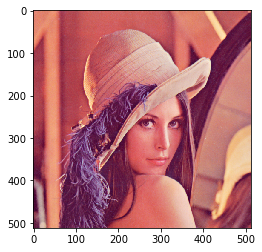

In [30]:
filepath = 'lena_std.tif'

img = load_image(filepath)
plt.imshow(img)

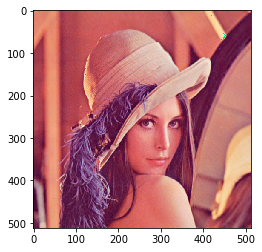

In [38]:
def setZeros(U, S, V, k):
    r = len(S)
    for i in range(k, r):
        U[:, i] = 0
        S[i] = 0
        V[i, :] = 0
    return U, S, V

def img_process(img, k):
    img2 = np.zeros_like(img)
    for c in range(img.shape[2]):
        A = img[:,:,c]
        U, S, V = svd(A)
        U, S, V = setZeros(U, S, V, k)
        img2[:,:,c] = rebuildsvd(U, S, V)
    return img2
img2 = img_process(img, 128)
plt.imshow(img2)